In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = '/home/abhay/coding/DLS/'

In [3]:
def load_dataset():
    train_dataset = h5py.File(PATH+'datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(PATH+'datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    classes = np.char.decode(classes)
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes = load_dataset()

In [5]:
print(f'X train Shape - {train_set_x_orig.shape}')
print(f'Y train Shape - {train_set_y_orig.shape}')
print(f'X test Shape - {test_set_x_orig.shape}')
print(f'Y test Shape - {test_set_y_orig.shape}')
print(f'Classes - {classes}')

X train Shape - (209, 64, 64, 3)
Y train Shape - (1, 209)
X test Shape - (50, 64, 64, 3)
Y test Shape - (1, 50)
Classes - ['non-cat' 'cat']


Y = [1] and it is cat


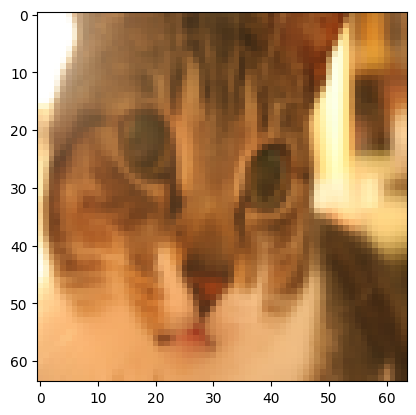

In [6]:
index = 200
plt.imshow(train_set_x_orig[index])
print(f'Y = {train_set_y_orig[:,index]} and it is {classes[np.squeeze(train_set_y_orig[:,index])]}')

In [7]:
#Flatten
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [8]:
print(f'Flattened shape of X train = {train_set_x_flatten.shape}')
print(f'Flattened shape of X test = {test_set_x_flatten.shape}')

Flattened shape of X train = (12288, 209)
Flattened shape of X test = (12288, 50)


In [9]:
#Normalize
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

In [10]:
#Activation Functions
def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.square(np.tanh(x))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def d_sigmoid(x):
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x):
    return np.maximum(0,x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

#Loss Functions
def logloss(y, a):
    return -(y*np.log(a) + (1 - y)*np.log(1 - a))

def d_logloss(y, a):
    return (a - y)/(a*(1 - a))

def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (-1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T))
    cost = np.squeeze(cost)      

    return cost

In [11]:
def initializeWeights(nx,ny):
    '''
    nx = No of inputs or No of neurons in prev layer
    ny = No of neurons in current layer
    '''
    w = np.random.randn(ny,nx)*0.01
    b = np.zeros((ny,1))
    
    return w,b

w,b = initializeWeights(2,3)
print(w,w.shape)
print(b.shape)

[[ 0.00585109 -0.00177   ]
 [-0.00172445  0.010507  ]
 [-0.0187232  -0.0091474 ]] (3, 2)
(3, 1)


In [12]:
#Layer class
class Layer:
    
    activationFunctions = {
            'tanh' : (tanh,d_tanh),
            'sigmoid' : (sigmoid,d_sigmoid),
            'relu' : (relu, d_relu)
        }
    np.random.seed(3)
    
    def __init__(self, inputs, neurons, activation, learning_rate=0.002):
        '''
        inputs = No of inputs to the current layer
        neurons = No of neurons in the current layer
        activation = Activation function for the currenrt layer
        '''
        self.W,self.b = initializeWeights(nx=inputs, ny=neurons)
        self.act, self.d_act = self.activationFunctions.get(activation)
        self.learning_rate = learning_rate
    
    def forwardProp(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(self.W, self.A_prev) + self.b
        self.A = self.act(self.Z)
        return self.A
    
    def backProp(self, dA):
        dZ = np.multiply(self.d_act(self.Z),dA)
        dW = 1/dZ.shape[1] * (np.dot(dZ,self.A_prev.T))
        db = 1/dZ.shape[1] * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T,dZ)
        
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        
        return dA_prev

In [13]:
class NNmodel:
    def __init__(self, epochs):
        self.epochs = epochs
        self.layers = []
        self.costs = []

    def add(self, layer):
        self.layers.append(layer)
        
    def fit(self, x_train, y_train):
        for epoch in range(self.epochs):
            A = x_train
            for layer in self.layers:
                A = layer.forwardProp(A)
                
            cost = 1/y_train.shape[1] * np.sum(logloss(y=y_train,a=A))
            self.costs.append(cost)
            dA = d_logloss(y_train, A)
    
            for layer in reversed(self.layers):
                dA = layer.backProp(dA)
            if epoch%100==0:
                print(f'At epoch - {epoch}, cost - {cost:0.10f}')
    
    def predict(self, X):
        A = X
        for layer in self.layers:
            A = layer.forwardProp(A)
        A = np.where(A<0.5, 0, 1)
        return A

In [14]:
epochs = 15001
inputs = train_set_x.shape[0]

model = NNmodel(epochs=epochs)
model.add(Layer(inputs=inputs, neurons=5, activation='relu'))
model.add(Layer(inputs=5, neurons=1, activation='sigmoid'))
model.fit(x_train=train_set_x, y_train=train_set_y_orig)

At epoch - 0, cost - 0.6927425808
At epoch - 100, cost - 0.6838505108
At epoch - 200, cost - 0.6602591287
At epoch - 300, cost - 0.6487103964
At epoch - 400, cost - 0.6459642569
At epoch - 500, cost - 0.6431568509
At epoch - 600, cost - 0.6397456414
At epoch - 700, cost - 0.6354344505
At epoch - 800, cost - 0.6298868557
At epoch - 900, cost - 0.6228168558
At epoch - 1000, cost - 0.6138416191
At epoch - 1100, cost - 0.6036209355
At epoch - 1200, cost - 0.5930135232
At epoch - 1300, cost - 0.5820045105
At epoch - 1400, cost - 0.5710515880
At epoch - 1500, cost - 0.5593686249
At epoch - 1600, cost - 0.5476848773
At epoch - 1700, cost - 0.5358496652
At epoch - 1800, cost - 0.5236870722
At epoch - 1900, cost - 0.5113420551
At epoch - 2000, cost - 0.4991253208
At epoch - 2100, cost - 0.4870826212
At epoch - 2200, cost - 0.4744764640
At epoch - 2300, cost - 0.4608550027
At epoch - 2400, cost - 0.4456277861
At epoch - 2500, cost - 0.4287041790
At epoch - 2600, cost - 0.4119578675
At epoch - 27

In [15]:
def getAccuracy(Y,predictions):
    return float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)

In [16]:
train_preds = model.predict(train_set_x)
test_preds = model.predict(test_set_x)

train_acc = getAccuracy(Y=train_set_y_orig, predictions=train_preds)
test_acc = getAccuracy(Y=test_set_y_orig, predictions=test_preds)

print(f'Train Accuracy - {train_acc}\nTest Accuracy - {test_acc}')

Train Accuracy - 100.0
Test Accuracy - 70.0


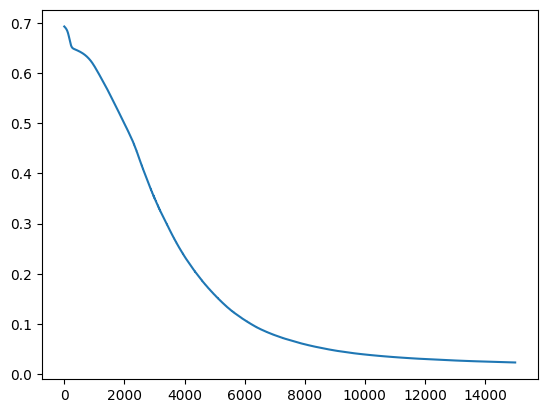

In [17]:
plt.plot(range(epochs),model.costs)